<div align="center"><h1>
FYS-STK4155 - Exercises Week 41
</div>
<hr style="border:2px solid gray"> </hr>
<div align="center"><h3>
Håvard Skåli
</div>

In [69]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, Kfold
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample

plt.rcParams.update({'text.usetex': True, 'font.size': 16, 'font.family': 'serif', 'font.serif': 'Computer Modern Sans Serif', 'font.weight': 100, 'mathtext.fontset': 'cm', 'xtick.labelsize': 14, 'ytick.labelsize': 14})

seed = 42
np.random.seed(seed)

ImportError: cannot import name 'Kfold' from 'sklearn.model_selection' (/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/__init__.py)

### Useful functions from Project 1, slightly altered to fit this week's exercises

In [12]:
def MSE(y: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Calculates the Mean Squared Error (MSE) between the true and predicted values.

    ## Parameters:
    y (np.ndarray): The actual data values.
    y_pred (np.ndarray): The predicted data values from the model.

    ## Returns:
    float: The Mean Squared Error.
    """
    y = y.flatten()
    y_pred = y_pred.flatten()
    n = len(y)
    return np.sum((y - y_pred)**2) / n

def R2(y: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Calculates the R2 score of the model.

    ## Parameters:
    y (np.ndarray): The actual data values.
    y_pred (np.ndarray): The predicted data values from the model.

    ## Returns:
    float: The R2 score.
    """
    y = y.flatten()
    y_pred = y_pred.flatten()
    return 1 - np.sum((y - y_pred)**2) / np.sum((y - np.mean(y))**2)

def create_X(x: np.ndarray, n: int) -> np.ndarray:
    """
    Creates the design matrix X.

    ## Parameters:
    x (np.ndarray): Independent variable.
    n (int): The degree of the polynomial features.

    ## Returns:
    np.ndarray: The design matrix X.
    """
    if len(x.shape) > 1:
        x = np.ravel(x)

    l = int(n+1)                    # Number of columns in the design matrix
    X = np.ones((len(x), l))

    idx = 1
    for i in range(1, l):
        X[:, i] = x**i

    return X

### Updated versions of the OLS and Ridge functions from Project 1

#### OLS

In [320]:
def OLS(x: np.ndarray, y: np.ndarray, degree: int, eta: float | None = None, n_iter: int = 100, scale: bool = True, linreg: bool = False, test_size: float = 0.2, seed: int | None = None, return_beta: bool = False, return_X: bool = False, return_scalers: bool = False) -> tuple[np.ndarray]:
    '''
    Performs Ordinary Least Squares (OLS) regression.

    ## Parameters:
    x (array-like): The independent variable.
    y (array-like): The dependent variable.
    degree (int): The degree of the polynomial features.
    eta (float | None, optional): The learning rate. If passed as None, it is computed from the Hessian matrix. Default is None.
    n_iter (int, optional): The number of iterations to perform in gradient descent. Default is 100. 
    scale (bool, optional): Whether to scale the data. Default is True.
    linreg (bool, optional): Whether to perform linear regression in addition to gradient descent. Default is False.
    test_size (float, optional): The proportion of the dataset to include in the test split. Default is 0.2.
    seed(int | None, optional): The random seed for reproducibility. Default is None.
    return beta (bool, optional): Whether to return the features β. Default is False.
    return_X (bool, optional): Whether to return X. Default is False.
    return_scalers (bool, optional): Whether to return the scalers used to scale the data. Default is False.

    ## Returns:
    tuple: A tuple containing the Mean Squared Error (MSE) score and the R-squared (R2) score, as well as the beta values (coefficients), the design matrix X, and/or the scalers for X and y, depending on the passed arguments. If linreg is passed as True, MSE_score, R2_score and β are lists of length 2, where the last elements are those obtained using linear regression.
    '''
    np.random.seed(seed)
    
    X = create_X(x, degree)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = seed)

    if scale: # Scaling the data
        scaler_X = StandardScaler().fit(X_train)
        X_train = scaler_X.transform(X_train)
        X_test = scaler_X.transform(X_test)

        scaler_y = StandardScaler().fit(y_train)
        y_train = scaler_y.transform(y_train)
        y_test= scaler_y.transform(y_test)

    if eta is None:
        H = (2.0 / len(x)) * X_train.T @ X_train
        eigvals, eigvecs = np.linalg.eig(H)
        eta = 1.0 / np.max(eigvals)

    # Estimating β's with gradient descent
    β = np.random.randn(degree + 1, 1)
    for iter in range(n_iter):
        gradient = (2.0 / len(x)) * X_train.T @ (X_train @ β - y_train)
        β -= eta * gradient
    
    y_pred = X_test @ β
    
    MSE_score = MSE(y_test, y_pred)
    R2_score = R2(y_test, y_pred)

    if linreg: # Performing linear regression as well
        β = [β, np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ y_train]
    
        y_pred = X_test @ β[-1]
    
        MSE_score = [MSE_score, MSE(y_test, y_pred)]
        R2_score = [R2_score, R2(y_test, y_pred)]

    quantities = [MSE_score, R2_score]
    if return_beta:
        quantities.append(β)
    if return_X:
        quantities.append(X)
    if return_scalers:
        quantities.extend([scaler_X, scaler_y])
    return tuple(quantities)

#### Ridge

In [321]:
def Ridge(x: np.ndarray, y: np.ndarray, degree: int, λ: float, eta: float | None = None, n_iter: int = 100, scale: bool = True, linreg: bool = False, test_size: float = 0.2, seed: int | None = None, return_beta: bool = False, return_X: bool = False, return_scalers: bool = False) -> tuple[np.ndarray]:
    """
    Performs Ridge regression.

    ## Parameters:
    x (np.ndarray): The independent variable.
    y (np.ndarray): The dependent variable.
    degree (int): The degree of the polynomial features.
    λ (float): The regularization parameter.
    eta (float | None, optional): The learning rate. If passed as None, it is computed from the Hessian matrix. Default is None.
    n_iter (int, optional): The number of iterations to perform in gradient descent. Default is 100. 
    scale (bool, optional): Whether to scale the data. Default is True.
    linreg (bool, optional): Whether to perform linear regression in addition to gradient descent. Default is False.
    test_size (float, optional): The proportion of the dataset to include in the test split. Default is 0.2.
    seed(int | None, optional): The random seed for reproducibility. Default is None.
    return beta (bool, optional): Whether to return the features β. Default is False.
    return_X (bool, optional): Whether to return X. Default is False.
    return_scalers (bool, optional): Whether to return the scalers used to scale the data. Default is False.

    ## Returns:
    tuple: A tuple containing of length 2-10, containing the Mean Squared Error (MSE) score and the R-squared (R2) score, as well as the beta values (coefficients), the design matrix X, and/or the scalers for X and y, depending on the passed arguments. If linreg is passed as True, MSE_score, R2_score and β are lists of length 2, where the last elements are those obtained using linear regression.
    """
    np.random.seed(seed)
    
    X = create_X(x, degree)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = seed)

    if scale: # Scaling the data
        scaler_X = StandardScaler().fit(X_train)
        X_train = scaler_X.transform(X_train)
        X_test = scaler_X.transform(X_test)

        scaler_y = StandardScaler().fit(y_train)
        y_train = scaler_y.transform(y_train)
        y_test = scaler_y.transform(y_test)
    
    if eta is None:
        H = 2.0 * ((1.0 / len(x)) * X_train.T @ X_train + λ * np.eye(X_train.shape[1]))
        eigvals, eigvecs = np.linalg.eig(H)
        eta = 1.0 / np.max(eigvals)

    # Estimating β's with gradient descent
    β = np.random.randn(degree + 1, 1)
    for iter in range(n_iter):
        gradient = 2.0 * ((1.0 / len(x)) * X_train.T @ (X_train @ β - y_train) + λ * β)
        β -= eta * gradient
    
    y_pred = X_test @ β
    
    MSE_score = MSE(y_test, y_pred)
    R2_score = R2(y_test, y_pred)

    if linreg: # Performing linear regression as well
        β = [β, np.linalg.pinv(X_train.T @ X_train + λ * np.eye(X_train.shape[1])) @ X_train.T @ y_train]
    
        y_pred = X_test @ β[-1]
    
        MSE_score = [MSE_score, MSE(y_test, y_pred)]
        R2_score = [R2_score, R2(y_test, y_pred)]

    quantities = [MSE_score, R2_score]
    if return_beta:
        quantities.append(β)
    if return_X:
        quantities.append(X)
    if return_scalers:
        quantities.extend([scaler_X, scaler_y])
    return tuple(quantities)

### Defining a simple 1D polynomial function

In [6]:
def f(x, coeffs):
    y = 0
    for i, coeff in enumerate(coeffs):
        y += coeff * x**(i)
    return y

### Comparing gradient descent and linear regression results for OLS

#### Trying $\eta=0.05$, $n_\text{iter}=100$, third order polynomial, $100$ data points and $\sigma=15$

In [323]:
n = 100
x = np.linspace(-3, 5, n).reshape(-1, 1)
coeffs = [2.0, 1.5, 0.5, 1.0]
y_true = f(x, coeffs)
y = y_true + np.random.normal(0.0, 15, (n, 1))

In [324]:
MSE_scores, R2_scores, βs, X, scaler_X, scaler_y = OLS(x, y, len(coeffs)-1, eta = 0.05, linreg = True, seed = seed, return_beta = True, return_X = True, return_scalers = True)

# Printing results
print(f"Gradient descent:\n     MSE = {MSE_scores[0]}, R^2 = {R2_scores[0]}\n     β = {[float(β) for β in βs[0]]}\nLinear regression:\n     MSE = {MSE_scores[1]}, R^2 = {R2_scores[1]}\n     β = {[float(β) for β in βs[1]]}")

Gradient descent:
     MSE = 0.13684819386989605, R^2 = 0.7896832828026068
     β = [0.4967141530112327, 0.047418339807384254, 0.006991506725685701, 0.9220430400910983]
Linear regression:
     MSE = 0.1403610688550213, R^2 = 0.7842844805685139
     β = [0.0, 0.24230727456865575, 0.2044615489659505, 0.5551296907412222]


In [238]:
#TODO why is β0 only zero for linear regression?

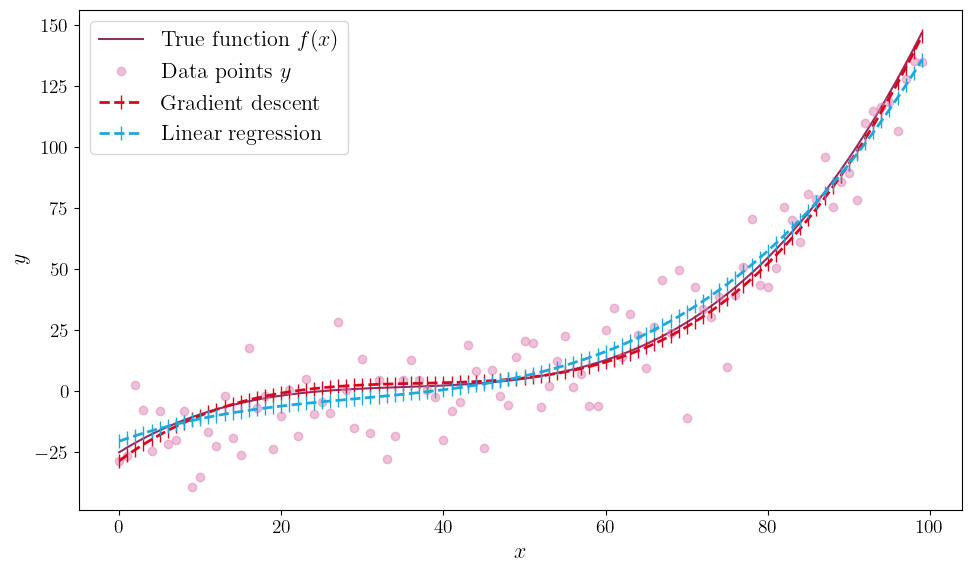

In [325]:
# Predicting
y_pred_GD = scaler_y.inverse_transform(scaler_X.transform(X) @ βs[0])
y_pred_linreg = scaler_y.inverse_transform(scaler_X.transform(X) @ βs[1])

# Plotting results
plt.figure(figsize = (10, 6))
plt.plot(y_true, color = "#8d3063", label = r"True function $f(x)$")
plt.plot(y, "o", color = "#de82b4", alpha = 0.5, label = r"Data points $y$")
plt.plot(y_pred_GD, "|--", color = "#d60620", markersize = 10, linewidth = 2, label = r"Gradient descent")
plt.plot(y_pred_linreg, "|--", color = "#20a7db", markersize = 10, linewidth = 2, label = "Linear regression")
plt.legend()
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.tight_layout()
plt.show()

#### Increasing the noise to $\sigma=30$

In [326]:
y = y_true + np.random.normal(0.0, 30, (n, 1))

In [329]:
MSE_scores, R2_scores, βs, X, scaler_X, scaler_y = OLS(x, y, len(coeffs)-1, eta = 0.05, linreg = True, seed = seed, return_beta = True, return_X = True, return_scalers = True)

# Printing results
print(f"Gradient descent:\n     MSE = {MSE_scores[0]}, R^2 = {R2_scores[0]}\n     β = {[float(β) for β in βs[0]]}\nLinear regression:\n     MSE = {MSE_scores[1]}, R^2 = {R2_scores[1]}\n     β = {[float(β) for β in βs[1]]}")

Gradient descent:
     MSE = 0.45124431709815555, R^2 = 0.45545802125869717
     β = [0.4967141530112327, 0.09341000045419877, -0.0160036120486312, 0.7958063288276054]
Linear regression:
     MSE = 0.4664434572259294, R^2 = 0.43711636126047504
     β = [0.0, 0.36811412926963316, 0.29859190656887064, 0.24425997390303672]


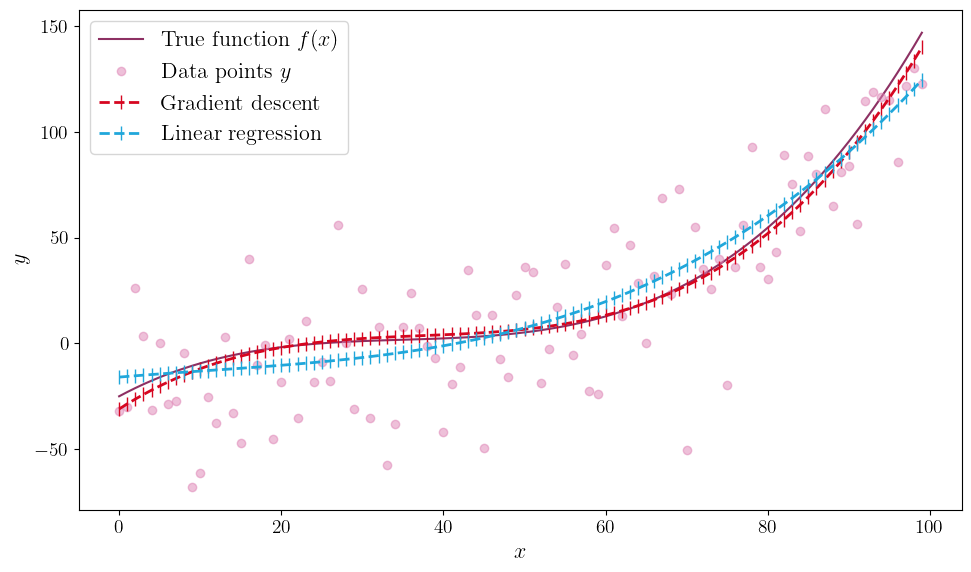

In [330]:
# Predicting
y_pred_GD = scaler_y.inverse_transform(scaler_X.transform(X) @ βs[0])
y_pred_linreg = scaler_y.inverse_transform(scaler_X.transform(X) @ βs[1])

# Plotting results
plt.figure(figsize = (10, 6))
plt.plot(y_true, color = "#8d3063", label = r"True function $f(x)$")
plt.plot(y, "o", color = "#de82b4", alpha = 0.5, label = r"Data points $y$")
plt.plot(y_pred_GD, "|--", color = "#d60620", markersize = 10, linewidth = 2, label = r"Gradient descent")
plt.plot(y_pred_linreg, "|--", color = "#20a7db", markersize = 10, linewidth = 2, label = "Linear regression")
plt.legend()
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.tight_layout()
plt.show()

#### Decreasing the learning rate to $\eta=0.01$

In [331]:
MSE_scores, R2_scores, βs, X, scaler_X, scaler_y = OLS(x, y, len(coeffs)-1, eta = 0.01, linreg = True, seed = seed, return_beta = True, return_X = True, return_scalers = True)

# Printing results
print(f"Gradient descent:\n     MSE = {MSE_scores[0]}, R^2 = {R2_scores[0]}\n     β = {[float(β) for β in βs[0]]}\nLinear regression:\n     MSE = {MSE_scores[1]}, R^2 = {R2_scores[1]}\n     β = {[float(β) for β in βs[1]]}")

Gradient descent:
     MSE = 0.4912716320007503, R^2 = 0.40715480183883035
     β = [0.4967141530112327, -0.2803584832005518, 0.11824200778481066, 1.0279425431960931]
Linear regression:
     MSE = 0.4664434572259294, R^2 = 0.43711636126047504
     β = [0.0, 0.36811412926963316, 0.29859190656887064, 0.24425997390303672]


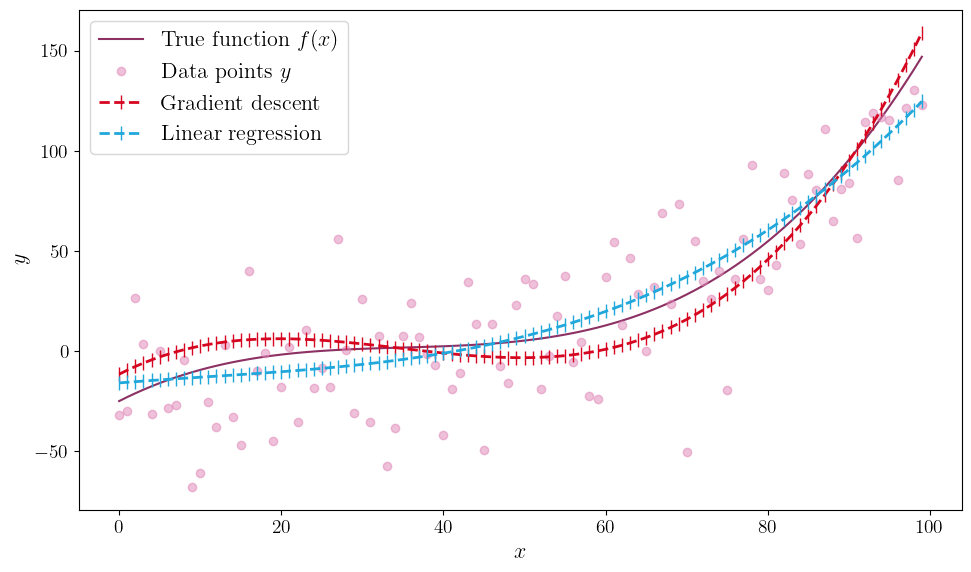

In [332]:
# Predicting
y_pred_GD = scaler_y.inverse_transform(scaler_X.transform(X) @ βs[0])
y_pred_linreg = scaler_y.inverse_transform(scaler_X.transform(X) @ βs[1])

# Plotting results
plt.figure(figsize = (10, 6))
plt.plot(y_true, color = "#8d3063", label = r"True function $f(x)$")
plt.plot(y, "o", color = "#de82b4", alpha = 0.5, label = r"Data points $y$")
plt.plot(y_pred_GD, "|--", color = "#d60620", markersize = 10, linewidth = 2, label = r"Gradient descent")
plt.plot(y_pred_linreg, "|--", color = "#20a7db", markersize = 10, linewidth = 2, label = "Linear regression")
plt.legend()
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.tight_layout()
plt.show()

#### Increasing the learning rate to $\eta=0.1$

In [333]:
MSE_scores, R2_scores, βs, X, scaler_X, scaler_y = OLS(x, y, len(coeffs)-1, eta = 0.1, linreg = True, seed = seed, return_beta = True, return_X = True, return_scalers = True)

# Printing results
print(f"Gradient descent:\n     MSE = {MSE_scores[0]}, R^2 = {R2_scores[0]}\n     β = {[float(β) for β in βs[0]]}\nLinear regression:\n     MSE = {MSE_scores[1]}, R^2 = {R2_scores[1]}\n     β = {[float(β) for β in βs[1]]}")

Gradient descent:
     MSE = 0.45076245962005423, R^2 = 0.4560395058661577
     β = [0.4967141530112327, 0.2100026306039425, 0.0538817197449062, 0.6220402560953954]
Linear regression:
     MSE = 0.4664434572259294, R^2 = 0.43711636126047504
     β = [0.0, 0.36811412926963316, 0.29859190656887064, 0.24425997390303672]


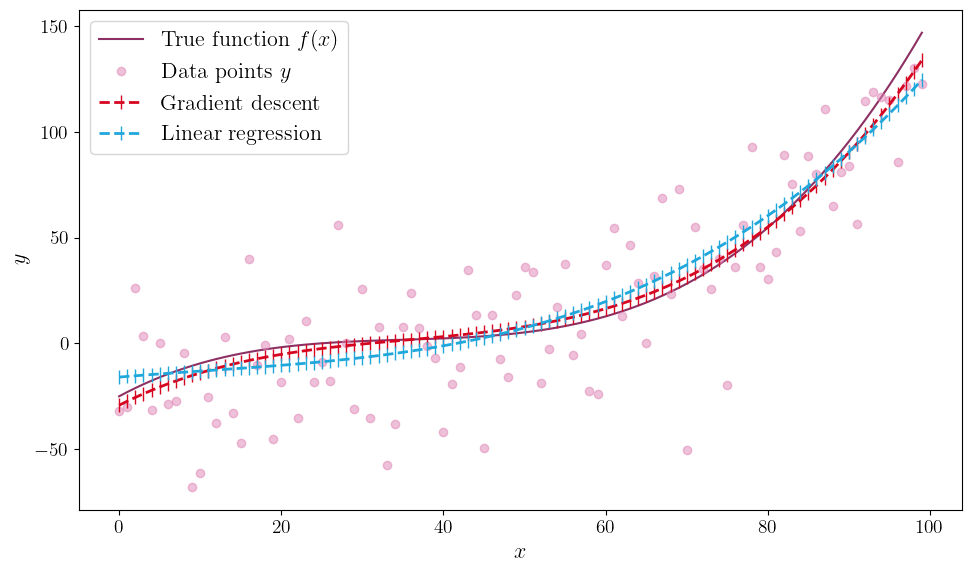

In [334]:
# Predicting
y_pred_GD = scaler_y.inverse_transform(scaler_X.transform(X) @ βs[0])
y_pred_linreg = scaler_y.inverse_transform(scaler_X.transform(X) @ βs[1])

# Plotting results
plt.figure(figsize = (10, 6))
plt.plot(y_true, color = "#8d3063", label = r"True function $f(x)$")
plt.plot(y, "o", color = "#de82b4", alpha = 0.5, label = r"Data points $y$")
plt.plot(y_pred_GD, "|--", color = "#d60620", markersize = 10, linewidth = 2, label = r"Gradient descent")
plt.plot(y_pred_linreg, "|--", color = "#20a7db", markersize = 10, linewidth = 2, label = "Linear regression")
plt.legend()
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.tight_layout()
plt.show()

#### Contour plotting MSE against $\eta\in[0.001,0.2]$ and $n_\text{iter}\in[1,1000]$

In [335]:
etas = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]
n_iters = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]

MSE_scores = []
for eta in etas:
    MSE_scores.append([])
    for n_iter in n_iters:
        MSE_score, R2_score = OLS(x, y, len(coeffs)-1, eta = eta, n_iter = n_iter, seed = seed)
        MSE_scores[-1].append(MSE_score)

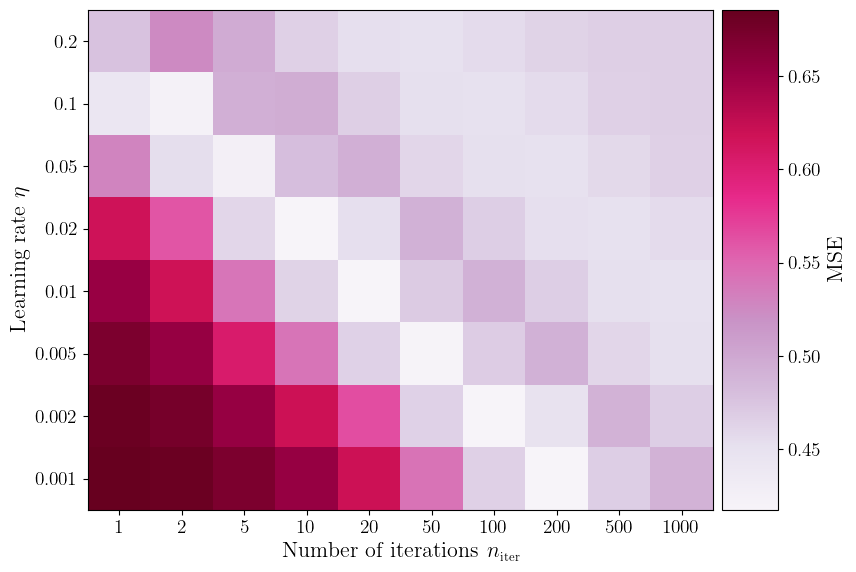

In [336]:
plt.figure(figsize = (10, 6))
im = plt.imshow(MSE_scores[::-1], cmap = "PuRd")
# plt.colorbar(im, label = r"$\log_{10}($MSE$)$", pad = 0.01, aspect = 9)
plt.colorbar(im, label = "MSE", pad = 0.01, aspect = 9)
plt.xlabel(r"Number of iterations $n_{\small\textrm{iter}}$")
plt.ylabel(r"Learning rate $\eta$")
plt.xticks([n_iters.index(n_iter) for n_iter in n_iters], labels = n_iters)
plt.yticks([etas[::-1].index(eta) for eta in etas[::-1]], labels = etas[::-1])
plt.tight_layout()
plt.show()

### Repeating the process for Ridge

#### Testing with $\lambda=0.1$

In [337]:
n = 100
x = np.linspace(-3, 5, n).reshape(-1, 1)
coeffs = [2.0, 1.5, 0.5, 1.0]
y_true = f(x, coeffs)
y = y_true + np.random.normal(0.0, 15, (n, 1))
λ = 0.1

In [338]:
MSE_scores, R2_scores, βs, X, scaler_X, scaler_y = Ridge(x, y, len(coeffs)-1, λ, eta = 0.05, linreg = True, seed = seed, return_beta = True, return_X = True, return_scalers = True)

# Printing results
print(f"Gradient descent:\n     MSE = {MSE_scores[0]}, R^2 = {R2_scores[0]}\n     β = {[float(β) for β in βs[0]]}\nLinear regression:\n     MSE = {MSE_scores[1]}, R^2 = {R2_scores[1]}\n     β = {[float(β) for β in βs[1]]}")

Gradient descent:
     MSE = 0.1468756745755671, R^2 = 0.7742724340062979
     β = [0.18181344437025068, 0.20233815058838303, 0.18917601856470032, 0.5628593652564312]
Linear regression:
     MSE = 0.14065216101898415, R^2 = 0.7838371122357994
     β = [0.0, 0.24434647857233766, 0.2078353931715116, 0.5495944845061647]


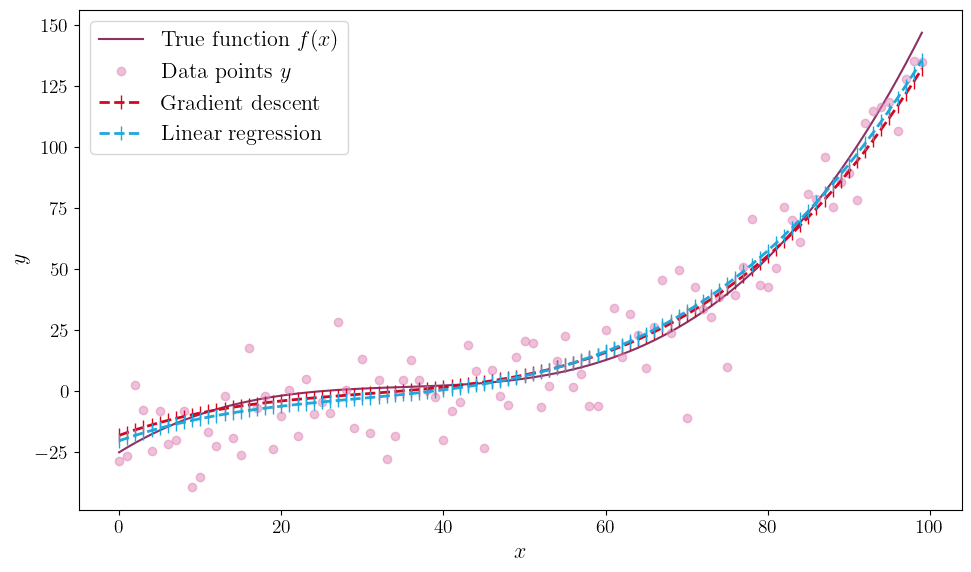

In [339]:
# Predicting
y_pred_GD = scaler_y.inverse_transform(scaler_X.transform(X) @ βs[0])
y_pred_linreg = scaler_y.inverse_transform(scaler_X.transform(X) @ βs[1])

# Plotting results
plt.figure(figsize = (10, 6))
plt.plot(y_true, color = "#8d3063", label = r"True function $f(x)$")
plt.plot(y, "o", color = "#de82b4", alpha = 0.5, label = r"Data points $y$")
plt.plot(y_pred_GD, "|--", color = "#d60620", markersize = 10, linewidth = 2, label = r"Gradient descent")
plt.plot(y_pred_linreg, "|--", color = "#20a7db", markersize = 10, linewidth = 2, label = "Linear regression")
plt.legend()
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.tight_layout()
plt.show()

#### Contour plotting MSE against $\eta\in[0.001,0.2]$ and $n_\text{iter}\in[1,1000]$

In [340]:
etas = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]
n_iters = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]

MSE_scores = []
for eta in etas:
    MSE_scores.append([])
    for n_iter in n_iters:
        MSE_score, R2_score = Ridge(x, y, len(coeffs)-1, λ, eta = eta, n_iter = n_iter, seed = seed)
        MSE_scores[-1].append(MSE_score)

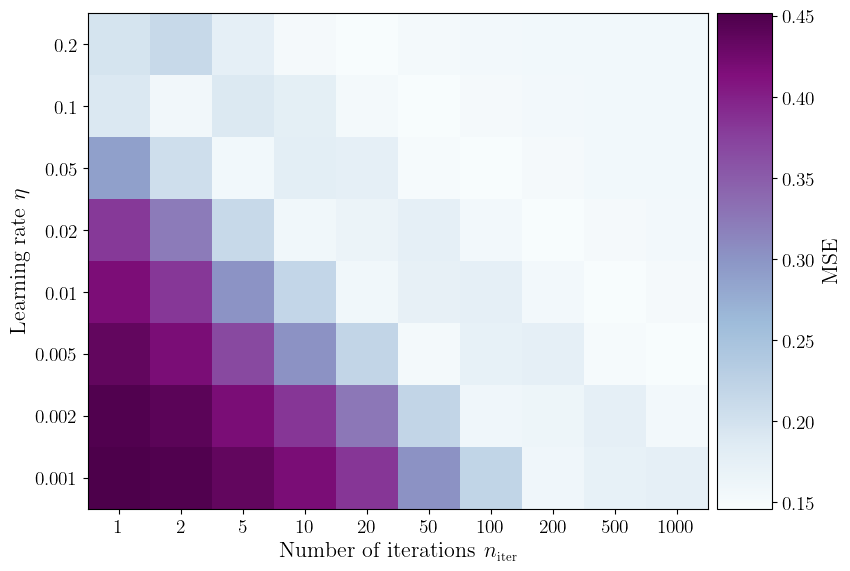

In [341]:
plt.figure(figsize = (10, 6))
im = plt.imshow(MSE_scores[::-1], cmap = "BuPu")
# plt.colorbar(im, label = r"$\log_{10}($MSE$)$", pad = 0.01, aspect = 9)
plt.colorbar(im, label = "MSE", pad = 0.01, aspect = 9)
plt.xlabel(r"Number of iterations $n_{\small\textrm{iter}}$")
plt.ylabel(r"Learning rate $\eta$")
plt.xticks([n_iters.index(n_iter) for n_iter in n_iters], labels = n_iters)
plt.yticks([etas[::-1].index(eta) for eta in etas[::-1]], labels = etas[::-1])
plt.tight_layout()
plt.show()

### Combining OLS and Ridge into one function, including momentum and SGD

In [342]:
!pip3 install autograd

In [63]:
from autograd import grad

def gradient_descent(x: np.ndarray, y: np.ndarray, degree: int, λ: float = 0.0, η: float | None = None, γ: float = 0.0, n_iter: int = 100, use_autograd: bool = False, stochastic: bool = False, n_epochs: int = 50, M: int = 5, tuning_method: str | None = None, tuning_params: list | None = None, scale: bool = True, linreg: bool = False, test_size: float = 0.2, seed: int | None = None, return_theta: bool = False, return_X: bool = False, return_scalers: bool = False) -> tuple[np.ndarray]:
    '''
    Performs various forms of gradient descent.

    ## Parameters:
    x (array-like): The independent variable.
    y (array-like): The dependent variable.
    degree (int): The degree of the polynomial features.
    λ (float, optional): The regularization parameter in Ridge regression. Passing as zero corresponds to OLS. Default is 0.0.
    η (float | None, optional): The learning rate. If passed as None, it is computed from the Hessian matrix. Default is None.
    γ (float, optional): The momentum parameter. Must be between 0.0 and 1.0. Passing as zero corresponds to using gradient descent without momentum. Default is 0.0.
    n_iter (int, optional): The number of iterations to perform in gradient descent. Default is 100. 
    use_autograd (bool, optional): Whether to use Autograd's grad function to compute the gradients. Default is False.
    stochastic (bool, optional): Whether to use stochastic gradient descent (SGD). If so, see args n_epochs, M, t0 and t1. Default is False.
    n_epochs (int, optional): Number of epochs to use in stochastic gradient descent if implemented. Default is 50.
    M (int, optional): Size of each minibatch in stochastic gradient descent if implemented. Default is 5.
    tuning_method (str | None, optional): Which tuning method to implement. The options are "decay", "AdaGrad", "RMSprop", "ADAM" and None. Default is None #TODO change, AdaGrad, RMSprop and ADAM are not tuning methods?
    tuning_params: (list, optional): List containing the parameters needed for the tuning method. If None, or if tuning_method is passed as None, no tuning is performed. Default is None. The expected signatures for the different metods are:
        "decay": [t0: int, t1: int]         # TODO example used t0 = 5 and t1 = 50
        "AdaGrad": [δ: float]               # TODO example used δ = 1e-8
        "RMSprop": [δ: float, ρ: float]     # TODO example used δ = 1e-8 and ρ = 0.99
        "ADAM": [δ: float, β1: float, β1: float]      # TODO example used β1 = 0.9 and β2 = 0.999
    scale (bool, optional): Whether to scale the data. Default is True.
    linreg (bool, optional): Whether to perform linear regression in addition to gradient descent. Default is False.
    test_size (float, optional): The proportion of the dataset to include in the test split. Default is 0.2.
    seed(int | None, optional): The random seed for reproducibility. Default is None.
    return_theta (bool, optional): Whether to return the features θ. Default is False.
    return_X (bool, optional): Whether to return X. Default is False.
    return_scalers (bool, optional): Whether to return the scalers used to scale the data. Default is False.

    ## Returns:
    tuple: A tuple containing the Mean Squared Error (MSE) score and the R-squared (R2) score, as well as the theta values (coefficients), the design matrix X, and/or the scalers for X and y, depending on the passed arguments. If linreg is passed as True, MSE_score, R2_score and θ are lists of length 2, where the last elements are those obtained using linear regression.
    '''
    np.random.seed(seed)

    if γ < 0.0 or γ > 1.0:
        print("The momentum parameter γ must be between 0.0 and 1.0! Setting to 0.0.")
        γ = 0.0
    
    if use_autograd:
        def cost_func(X, y, θ):
            if stochastic:
                return (1.0 / M) * np.sum((X @ θ - y)**2) + λ * np.sum(θ**2)
            else:
                return (1.0 / len(x)) * np.sum((X @ θ - y)**2) + λ * np.sum(θ**2)
        training_gradient = grad(cost_func, 2)
    else:
        def training_gradient(X, y, θ):
            if stochastic:
                return 2.0 * ((1.0 / M) * X.T @ (X @ θ - y) + λ * θ)
            else:
                return 2.0 * ((1.0 / len(x)) * X.T @ (X @ θ - y) + λ * θ)
    
    if tuning_method == "decay": # Uses a decaying learning rate
        t0, t1 = tuning_params
        def learning_schedule(t):
            return t0 / (t + t1)
    elif tuning_method == "AdaGrad": # Uses the AdaGrad tuning method
        δ = tuning_params[0]
    elif tuning_method == "RMSprop": # Uses the RMSprop tuning method
        δ, ρ = tuning_params
    elif tuning_method == "ADAM": # Uses the ADAM optimizer tuning method
        δ, β1, β2 = tuning_params

    X = create_X(x, degree)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = seed)

    if scale: # Scaling the data
        scaler_X = StandardScaler().fit(X_train)
        X_train = scaler_X.transform(X_train)
        X_test = scaler_X.transform(X_test)

        scaler_y = StandardScaler().fit(y_train)
        y_train = scaler_y.transform(y_train)
        y_test= scaler_y.transform(y_test)

    if η is None: # Setting the learning rate using the Hessian matrix
        H = 2.0 * ((1.0 / len(x)) * X_train.T @ X_train + λ * np.eye(X_train.shape[1]))
        eigvals, eigvecs = np.linalg.eig(H)
        η = 1.0 / np.max(eigvals)

    # Estimating θ's with gradient descent
    θ = np.random.randn(degree + 1, 1)
    change = 0.0
    
    if stochastic:
        m = int(len(x) / M) # Number of minibatches
        if tuning_method == "ADAM":
            iter = 0

        for epoch in range(1, n_epochs + 1):
            #TODO set change to zero at the start of every epoch?
            if tuning_method in ["AdaGrad", "RMSprop"]:
                Giter = 0.0
            elif tuning_method == "ADAM":
                first_moment, second_moment = 0.0, 0.0
                iter += 1

            for i in range(m):
                k = M*np.random.randint(m) # Pick the k-th minibatch at random
                Xi = X_train[k:k+M]
                yi = y_train[k:k+M]

                gradients = training_gradient(Xi, yi, θ)
                
                if tuning_method in [None, "decay"]:
                    if tuning_method == "decay":
                        t = epoch*m + i
                        η = learning_schedule(t)
                    new_change = η * gradients + γ * change
                    θ -= new_change
                    change = new_change 
                
                else:
                    if tuning_method in ["AdaGrad", "RMSprop"]:
                        gradients = training_gradient(Xi, yi, θ)
                        if tuning_method == "AdaGrad":
                            Giter += gradients*gradients
                        else:
                            Giter = (ρ * Giter + (1 - ρ) * gradients*gradients)
                        change = gradients * η /(δ + np.sqrt(Giter))
                    elif tuning_method == "ADAM":
                        first_moment = β1*first_moment + (1 - β1)*gradients
                        second_moment = β2*second_moment + (1 - β2)*gradients*gradients
                        first_term = first_moment / (1.0 - β1**iter)
                        second_term = second_moment / (1.0 - β2**iter)
                        change = η * first_term / (np.sqrt(second_term) + δ)
                    θ -= change
    
    else:
        for iter in range(n_iter):
            gradients = training_gradient(X_train, y_train, θ)
            new_change = η * gradients + γ * change
            θ -= new_change
            change = new_change 
    
    y_pred = X_test @ θ
    
    MSE_score = MSE(y_test, y_pred)
    R2_score = R2(y_test, y_pred)

    if linreg: # Performing linear regression as well
        θ = [θ, np.linalg.pinv(X_train.T @ X_train + λ * np.eye(X_train.shape[1])) @ X_train.T @ y_train]
    
        y_pred = X_test @ θ[-1]
    
        MSE_score = [MSE_score, MSE(y_test, y_pred)]
        R2_score = [R2_score, R2(y_test, y_pred)]

    quantities = [MSE_score, R2_score]
    if return_theta:
        quantities.append(θ)
    if return_X:
        quantities.append(X)
    if return_scalers:
        quantities.extend([scaler_X, scaler_y])
    return tuple(quantities)

### OLS using gradient descent with momentum

In [40]:
n = 100
x = np.linspace(-3, 5, n).reshape(-1, 1)
coeffs = [2.0, 1.5, 0.5, 1.0]
y_true = f(x, coeffs)
y = y_true + np.random.normal(0.0, 30, (n, 1))

In [41]:
MSE_scores, R2_scores, θs, X, scaler_X, scaler_y = gradient_descent(x, y, len(coeffs)-1, γ = 0.5, linreg = True, seed = seed, return_theta = True, return_X = True, return_scalers = True)

# Printing results
print(f"Gradient descent with momentum:\n     MSE = {MSE_scores[0]}, R^2 = {R2_scores[0]}\n     θ = {[float(θ) for θ in θs[0]]}\nLinear regression:\n     MSE = {MSE_scores[1]}, R^2 = {R2_scores[1]}\n     θ = {[float(θ) for θ in θs[1]]}")

Gradient descent with momentum:
     MSE = 0.22535395421034324, R^2 = 0.5404258338541008
     θ = [0.4967141530112327, 0.20015691452313164, -0.10538781219458908, 0.7280451183804]
Linear regression:
     MSE = 0.22522117284644194, R^2 = 0.5406966206916713
     θ = [0.0, 0.20333511980103736, -0.1002372030026881, 0.7202317187354501]


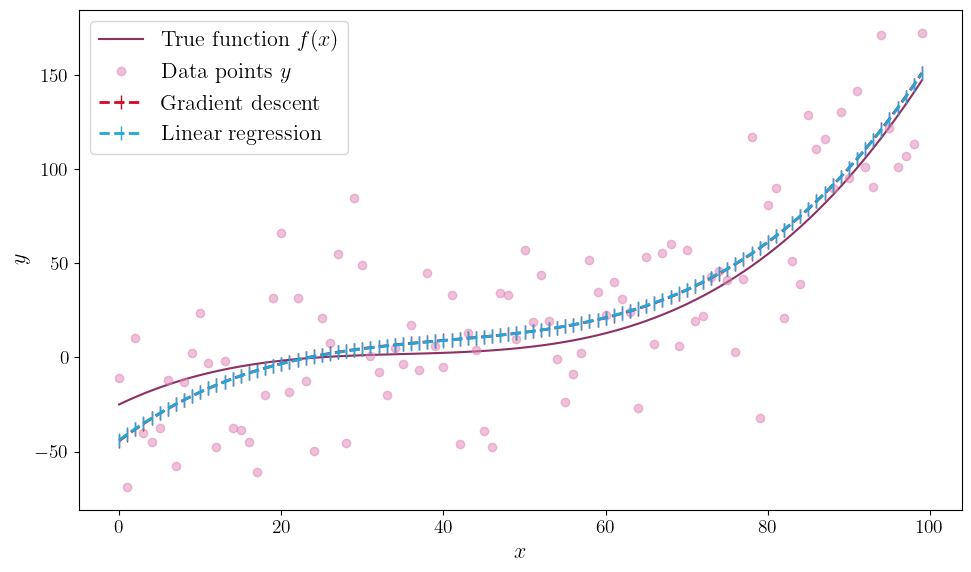

In [42]:
# Predicting
y_pred_GD = scaler_y.inverse_transform(scaler_X.transform(X) @ θs[0])
y_pred_linreg = scaler_y.inverse_transform(scaler_X.transform(X) @ θs[1])

# Plotting results
plt.figure(figsize = (10, 6))
plt.plot(y_true, color = "#8d3063", label = r"True function $f(x)$")
plt.plot(y, "o", color = "#de82b4", alpha = 0.5, label = r"Data points $y$")
plt.plot(y_pred_GD, "|--", color = "#d60620", markersize = 10, linewidth = 2, label = r"Gradient descent")
plt.plot(y_pred_linreg, "|--", color = "#20a7db", markersize = 10, linewidth = 2, label = "Linear regression")
plt.legend()
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.tight_layout()
plt.show()

### OLS: stochastic gradient descent with momentum, no tuning

In [45]:
MSE_scores, R2_scores, θs, X, scaler_X, scaler_y = gradient_descent(x, y, len(coeffs)-1, γ = 0.5, stochastic = True, linreg = True, seed = seed, return_theta = True, return_X = True, return_scalers = True)

# Printing results
print(f"Gradient descent with momentum:\n     MSE = {MSE_scores[0]}, R^2 = {R2_scores[0]}\n     θ = {[float(θ) for θ in θs[0]]}\nLinear regression:\n     MSE = {MSE_scores[1]}, R^2 = {R2_scores[1]}\n     θ = {[float(θ) for θ in θs[1]]}")

Gradient descent with momentum:
     MSE = 0.43469903978431323, R^2 = 0.11349925306023512
     θ = [0.4967141530112327, 0.07500732267774557, 0.32499612601838823, 1.0613431584165207]
Linear regression:
     MSE = 0.22522117284644194, R^2 = 0.5406966206916713
     θ = [0.0, 0.20333511980103736, -0.1002372030026881, 0.7202317187354501]


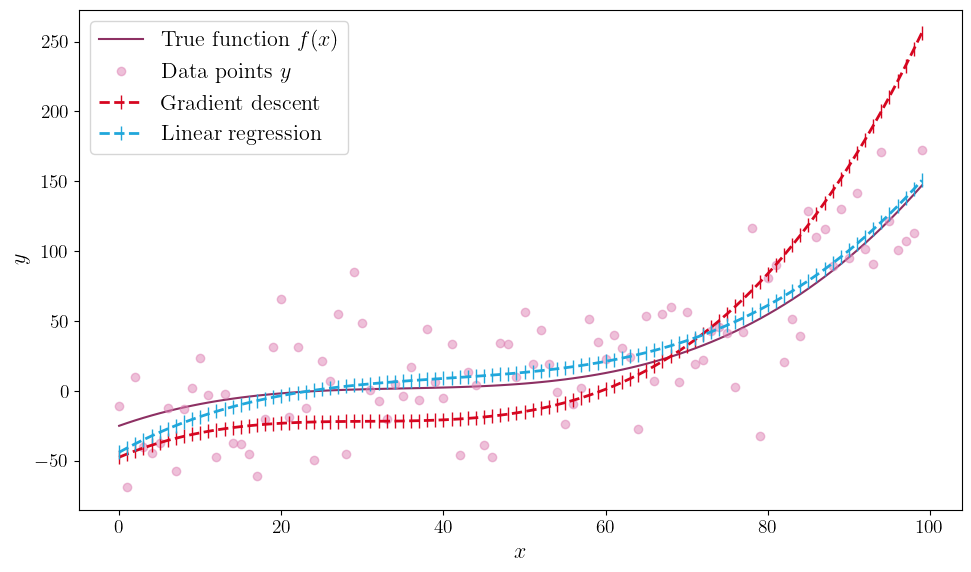

In [46]:
# Predicting
y_pred_GD = scaler_y.inverse_transform(scaler_X.transform(X) @ θs[0])
y_pred_linreg = scaler_y.inverse_transform(scaler_X.transform(X) @ θs[1])

# Plotting results
plt.figure(figsize = (10, 6))
plt.plot(y_true, color = "#8d3063", label = r"True function $f(x)$")
plt.plot(y, "o", color = "#de82b4", alpha = 0.5, label = r"Data points $y$")
plt.plot(y_pred_GD, "|--", color = "#d60620", markersize = 10, linewidth = 2, label = r"Gradient descent")
plt.plot(y_pred_linreg, "|--", color = "#20a7db", markersize = 10, linewidth = 2, label = "Linear regression")
plt.legend()
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.tight_layout()
plt.show()

### OLS: SGD with decaying learning rate, $t_0=5$ and $t_1=50$

In [47]:
MSE_scores, R2_scores, θs, X, scaler_X, scaler_y = gradient_descent(x, y, len(coeffs)-1, γ = 0.5, stochastic = True, tuning_method = "decay", tuning_params = [5, 50], linreg = True, seed = seed, return_theta = True, return_X = True, return_scalers = True)

# Printing results
print(f"Gradient descent with momentum:\n     MSE = {MSE_scores[0]}, R^2 = {R2_scores[0]}\n     θ = {[float(θ) for θ in θs[0]]}\nLinear regression:\n     MSE = {MSE_scores[1]}, R^2 = {R2_scores[1]}\n     θ = {[float(θ) for θ in θs[1]]}")

Gradient descent with momentum:
     MSE = 0.2189566307354216, R^2 = 0.5534721751612894
     θ = [0.4967141530112327, 0.13722631864850562, -0.12434513613600787, 0.7737535465345149]
Linear regression:
     MSE = 0.22522117284644194, R^2 = 0.5406966206916713
     θ = [0.0, 0.20333511980103736, -0.1002372030026881, 0.7202317187354501]


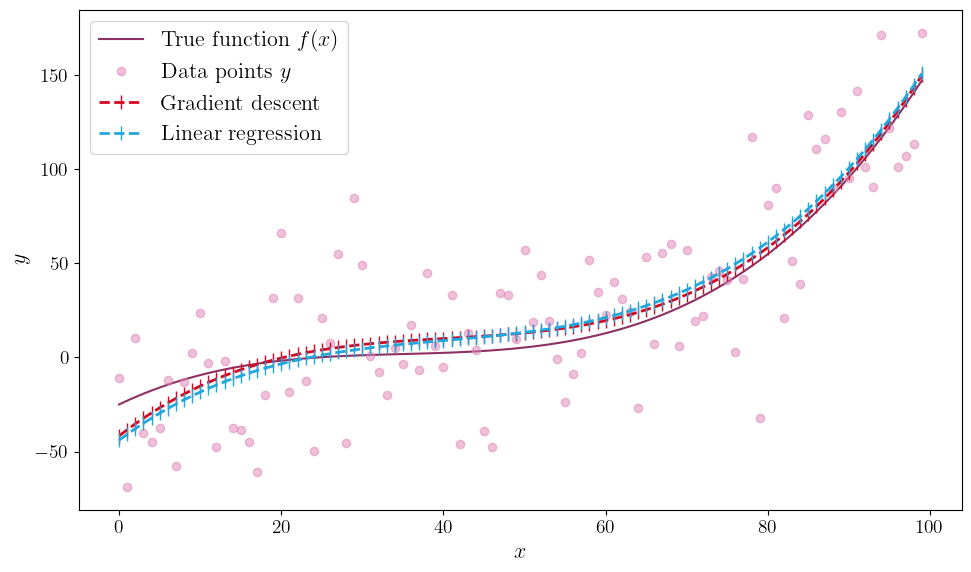

In [48]:
# Predicting
y_pred_GD = scaler_y.inverse_transform(scaler_X.transform(X) @ θs[0])
y_pred_linreg = scaler_y.inverse_transform(scaler_X.transform(X) @ θs[1])

# Plotting results
plt.figure(figsize = (10, 6))
plt.plot(y_true, color = "#8d3063", label = r"True function $f(x)$")
plt.plot(y, "o", color = "#de82b4", alpha = 0.5, label = r"Data points $y$")
plt.plot(y_pred_GD, "|--", color = "#d60620", markersize = 10, linewidth = 2, label = r"Gradient descent")
plt.plot(y_pred_linreg, "|--", color = "#20a7db", markersize = 10, linewidth = 2, label = "Linear regression")
plt.legend()
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.tight_layout()
plt.show()

### OLS: SGD with AdaGrad, $\delta=10^{-8}$

In [53]:
MSE_scores, R2_scores, θs, X, scaler_X, scaler_y = gradient_descent(x, y, len(coeffs)-1, γ = 0.5, stochastic = True, tuning_method = "AdaGrad", tuning_params = [1e-8], linreg = True, seed = seed, return_theta = True, return_X = True, return_scalers = True)

# Printing results
print(f"Gradient descent with momentum:\n     MSE = {MSE_scores[0]}, R^2 = {R2_scores[0]}\n     θ = {[float(θ) for θ in θs[0]]}\nLinear regression:\n     MSE = {MSE_scores[1]}, R^2 = {R2_scores[1]}\n     θ = {[float(θ) for θ in θs[1]]}")

Gradient descent with momentum:
     MSE = 0.28193000617251207, R^2 = 0.42504781887562015
     θ = [0.4967141530112327, -0.09933077046764092, -0.24056572610237204, 0.7784001646512604]
Linear regression:
     MSE = 0.22522117284644194, R^2 = 0.5406966206916713
     θ = [0.0, 0.20333511980103736, -0.1002372030026881, 0.7202317187354501]


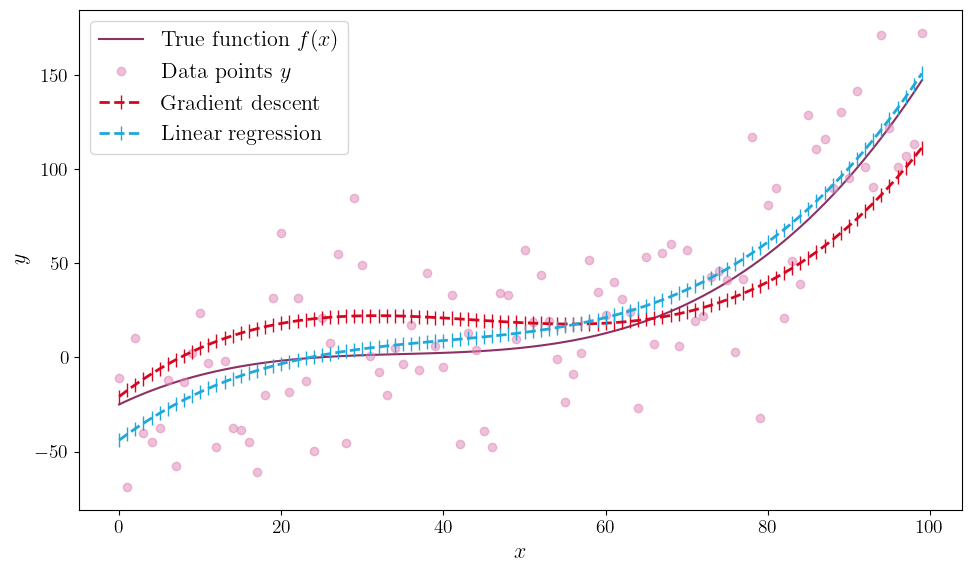

In [54]:
# Predicting
y_pred_GD = scaler_y.inverse_transform(scaler_X.transform(X) @ θs[0])
y_pred_linreg = scaler_y.inverse_transform(scaler_X.transform(X) @ θs[1])

# Plotting results
plt.figure(figsize = (10, 6))
plt.plot(y_true, color = "#8d3063", label = r"True function $f(x)$")
plt.plot(y, "o", color = "#de82b4", alpha = 0.5, label = r"Data points $y$")
plt.plot(y_pred_GD, "|--", color = "#d60620", markersize = 10, linewidth = 2, label = r"Gradient descent")
plt.plot(y_pred_linreg, "|--", color = "#20a7db", markersize = 10, linewidth = 2, label = "Linear regression")
plt.legend()
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.tight_layout()
plt.show()

### OLS: SGD with RMSprop, $\delta=10^{-10}$ and $\rho=0.9$

In [60]:
MSE_scores, R2_scores, θs, X, scaler_X, scaler_y = gradient_descent(x, y, len(coeffs)-1, γ = 0.5, stochastic = True, tuning_method = "RMSprop", tuning_params = [1e-10, 0.9], linreg = True, seed = seed, return_theta = True, return_X = True, return_scalers = True)

# Printing results
print(f"Gradient descent with momentum:\n     MSE = {MSE_scores[0]}, R^2 = {R2_scores[0]}\n     θ = {[float(θ) for θ in θs[0]]}\nLinear regression:\n     MSE = {MSE_scores[1]}, R^2 = {R2_scores[1]}\n     θ = {[float(θ) for θ in θs[1]]}")

Gradient descent with momentum:
     MSE = 0.22480957479025662, R^2 = 0.5415360105933107
     θ = [0.4967141530112327, 0.10188439323710044, -0.21763058703028093, 0.846046144253759]
Linear regression:
     MSE = 0.22522117284644194, R^2 = 0.5406966206916713
     θ = [0.0, 0.20333511980103736, -0.1002372030026881, 0.7202317187354501]


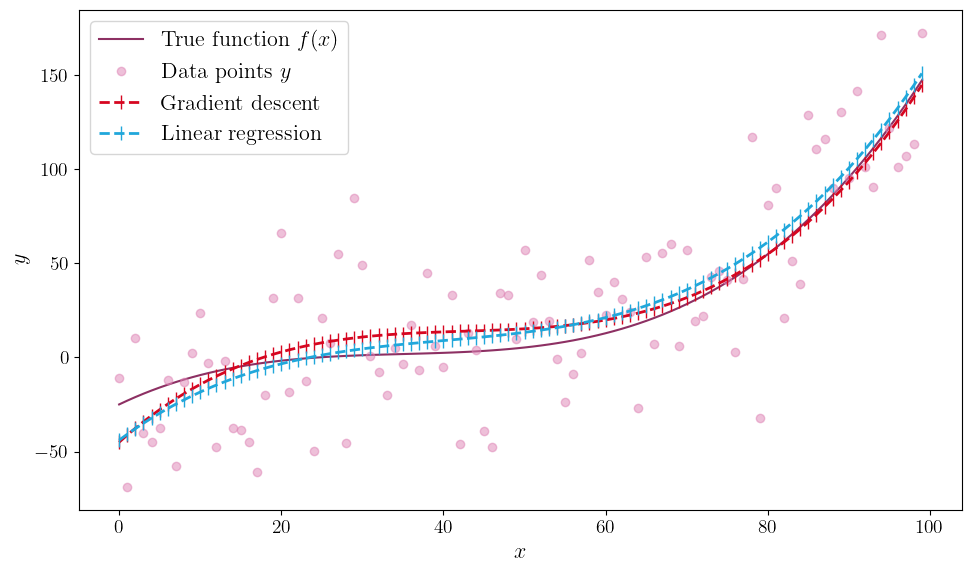

In [61]:
# Predicting
y_pred_GD = scaler_y.inverse_transform(scaler_X.transform(X) @ θs[0])
y_pred_linreg = scaler_y.inverse_transform(scaler_X.transform(X) @ θs[1])

# Plotting results
plt.figure(figsize = (10, 6))
plt.plot(y_true, color = "#8d3063", label = r"True function $f(x)$")
plt.plot(y, "o", color = "#de82b4", alpha = 0.5, label = r"Data points $y$")
plt.plot(y_pred_GD, "|--", color = "#d60620", markersize = 10, linewidth = 2, label = r"Gradient descent")
plt.plot(y_pred_linreg, "|--", color = "#20a7db", markersize = 10, linewidth = 2, label = "Linear regression")
plt.legend()
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.tight_layout()
plt.show()

### OLS: SGD with ADAM, $\delta=10^{-10}$, $\beta_1=0.9$ and $\beta_2=0.999$

In [64]:
MSE_scores, R2_scores, θs, X, scaler_X, scaler_y = gradient_descent(x, y, len(coeffs)-1, γ = 0.5, stochastic = True, tuning_method = "ADAM", tuning_params = [1e-10, 0.9, 0.999], linreg = True, seed = seed, return_theta = True, return_X = True, return_scalers = True)

# Printing results
print(f"Gradient descent with momentum:\n     MSE = {MSE_scores[0]}, R^2 = {R2_scores[0]}\n     θ = {[float(θ) for θ in θs[0]]}\nLinear regression:\n     MSE = {MSE_scores[1]}, R^2 = {R2_scores[1]}\n     θ = {[float(θ) for θ in θs[1]]}")

Gradient descent with momentum:
     MSE = 0.29913679168891405, R^2 = 0.3899572692845945
     θ = [0.4967141530112327, -0.22956723261630005, -0.29198836205919915, 0.9626790364072743]
Linear regression:
     MSE = 0.22522117284644194, R^2 = 0.5406966206916713
     θ = [0.0, 0.20333511980103736, -0.1002372030026881, 0.7202317187354501]


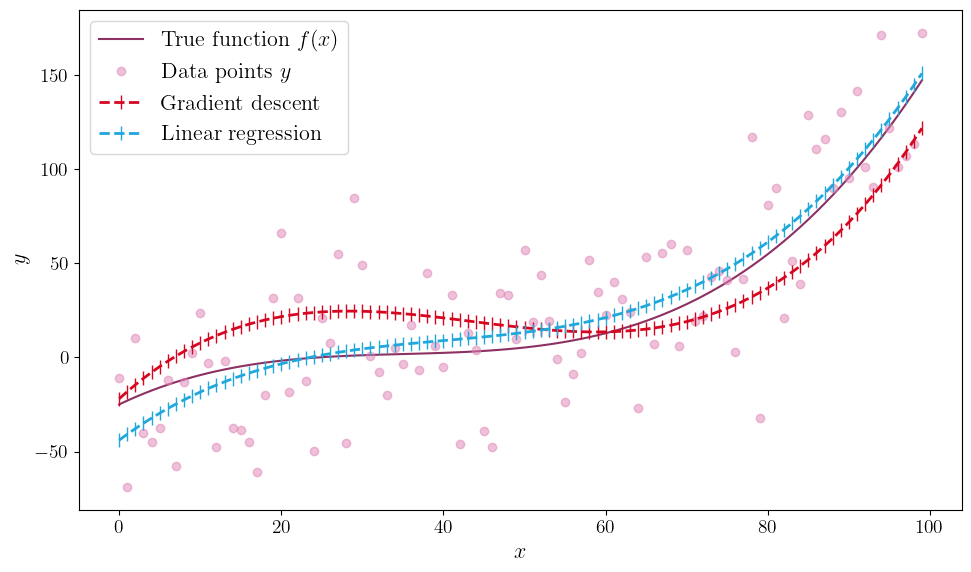

In [65]:
# Predicting
y_pred_GD = scaler_y.inverse_transform(scaler_X.transform(X) @ θs[0])
y_pred_linreg = scaler_y.inverse_transform(scaler_X.transform(X) @ θs[1])

# Plotting results
plt.figure(figsize = (10, 6))
plt.plot(y_true, color = "#8d3063", label = r"True function $f(x)$")
plt.plot(y, "o", color = "#de82b4", alpha = 0.5, label = r"Data points $y$")
plt.plot(y_pred_GD, "|--", color = "#d60620", markersize = 10, linewidth = 2, label = r"Gradient descent")
plt.plot(y_pred_linreg, "|--", color = "#20a7db", markersize = 10, linewidth = 2, label = "Linear regression")
plt.legend()
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.tight_layout()
plt.show()